# Create a Hushh Vibe Catalog

Download an example product catalog from this [Kaggle dataset](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small).


In [19]:
import glob
from hushh import catalog
from hushh.catalog import Catalog, Product
from PIL import Image
import json
from tqdm import tqdm
import pandas as pd
import msgpack
import os
import timeit

## Download Data
Uncomment and execute the next two cells to download/unzip the image dataset

In [2]:
# !kaggle datasets download paramaggarwal/fashion-product-images-small --force 

In [3]:
# ! unzip -o fashion-product-images-small.zip > /dev/null

## Data Details
The dataset contains around ~40K fashion related images

In [2]:
len(glob.glob("images/*"))

44441

Taking a quick look at the images, they're jpeg files, with an id as a file name.

In [3]:
print(glob.glob("images/*")[:10])

['images/9733.jpg', 'images/14147.jpg', 'images/52112.jpg', 'images/6400.jpg', 'images/34297.jpg', 'images/24084.jpg', 'images/12536.jpg', 'images/54563.jpg', 'images/15259.jpg', 'images/35189.jpg']


The "styles" csv file gives some of the metadata for a given id.

In [4]:
styles = pd.read_csv("styles.csv",usecols=range(10), index_col=0)
styles.head()

,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
id,,,,,,,,,
15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


## Creating a Hushh Catalog
We can create a catalog using the hushh catalog api.  We follow these steps for each image file:

1. Extract the id from the filename.
2. Lookup the metadata for the id.
3. Create a product for the id and metadata (using a dummy url, since we won't be linking to a product url).

The Catalog comes with its own method for writing catalog files.


In [ ]:

cat = Catalog("demo_catalog")

for filename in tqdm(glob.glob("images/*")):
    id, ext = os.path.splitext(os.path.basename(filename))
    id = int(id)
    style = styles.loc[id]
    if pd.isna(style.productDisplayName):
        pass
        # print(f"Skipping: {id}, product had no description")
    else:
        prod = Product(description=style.productDisplayName, url="dummy_url", image=filename)
        cat.addProduct(prod)

print("Writing Catalog")
cat.to_hcf("catalog.hcf")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44441/44441 [00:14<00:00, 3120.79it/s]


Writing Catalog
Collected images and text for batch 0
Collected inputs for batch 0
Collected Image and text features for batch 0
Image embeddings collected for batch 0
Text embeddings collected for batch 0
Collected images and text for batch 1
Collected inputs for batch 1
Collected Image and text features for batch 1
Image embeddings collected for batch 1
Text embeddings collected for batch 1
Collected images and text for batch 2
Collected inputs for batch 2
Collected Image and text features for batch 2
Image embeddings collected for batch 2
Text embeddings collected for batch 2
Collected images and text for batch 3
Collected inputs for batch 3


## Create a comparison JSON dataset
We will set up a quick and dirty json output for comparison.  This just dumps the flatbatch content from the catalog in standard json format.

In [6]:
with open ("catalog.json", "w") as fh:
    json.dump(cat.productVibes, fh, default=lambda o: o.__dict__)

# Create a comparison MsgPack dataset

In [41]:
with open ("catalog.msgpack", "wb") as fh:
    packed = msgpack.packb(cat.productVibes, default=lambda o: o.__dict__)
    fh.write(packed)

# Timings

In [47]:
import time
import numpy as np
def json_open():
    with open('catalog.json', 'r') as fh:
        json.load(fh)

def msg_open():
    with open('catalog.msgpack', 'rb') as fh:
        data_loaded = msgpack.unpackb(fh.read())

def hcf_open():
    catalog.read_hcf("test.hcf")
iter = 10

def timer(func, iterations=3):
    results = []
    for i in range(0,iterations):
        start = time.time()
        func()
        duration = time.time() - start
        results.append(duration)
    return results



hcf_result = timer(hcf_open, iter)
print(hcf_result)
msg_result = timer(msg_open, iter)
print(msg_result)
json_result = timer(json_open, iter)
print(json_result)


[0.0017621517181396484, 0.0009391307830810547, 0.0007212162017822266, 0.0009021759033203125, 0.0008409023284912109, 0.0009250640869140625, 0.0008530616760253906, 0.0006358623504638672, 0.0006289482116699219, 0.0006871223449707031]
[0.9692511558532715, 1.0034160614013672, 1.0053150653839111, 0.8395180702209473, 0.9242990016937256, 0.9968812465667725, 1.0046262741088867, 0.7576639652252197, 0.9129230976104736, 0.9955949783325195]
[7.44507908821106, 7.346750974655151, 7.513769865036011, 7.661447763442993, 7.529480934143066, 7.461015701293945, 7.61430025100708, 7.577383995056152, 7.6200478076934814, 7.3818018436431885]


In [49]:
import pandas as pd

dat= pd.DataFrame({"hcf" : hcf_result,"msgpack" : msg_result,  "json" : json_result})

In [50]:
dat

,hcf,json,msgpack
0,0.001762,7.445079,0.969251
1,0.000939,7.346751,1.003416
2,0.000721,7.513770,1.005315
3,0.000902,7.661448,0.839518
4,0.000841,7.529481,0.924299
5,0.000925,7.461016,0.996881
6,0.000853,7.614300,1.004626
7,0.000636,7.577384,0.757664
8,0.000629,7.620048,0.912923
9,0.000687,7.381802,0.995595


In [65]:
dat.to_csv("results.csv")

In [17]:
import pandas as pd
dat = pd.read_csv("results.csv", index_col = 0)

In [18]:
dat = dat[["hcf", "msgpack", "json"]]

In [19]:
dat.describe()

,hcf,msgpack,json
count,10.000000,10.000000,10.000000
mean,0.000890,0.940949,7.515108
std,0.000328,0.084301,0.105566
min,0.000629,0.757664,7.346751
25%,0.000696,0.915767,7.449063
50%,0.000847,0.982423,7.521625
75%,0.000919,1.001782,7.605071
max,0.001762,1.005315,7.661448


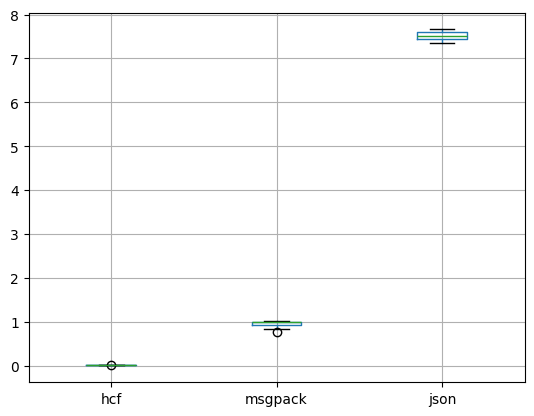

In [21]:
dat.boxplot();

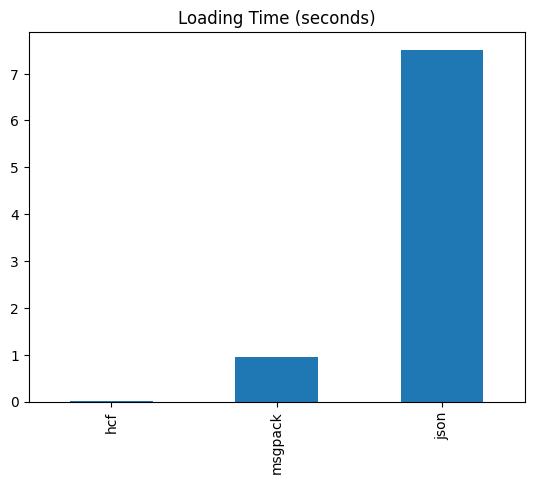

In [22]:
dat.mean().plot.bar(title="Loading Time (seconds)");

In [24]:
dat2 = pd.DataFrame({"hcf" : [179] ,"msgpack" : [357],  "json" : [834]})

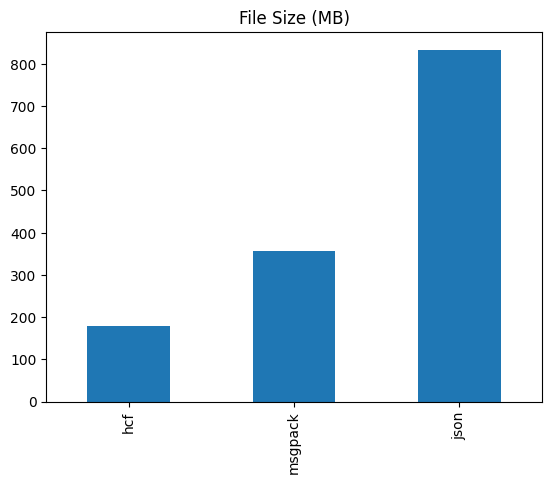

In [25]:
dat2.mean().plot.bar(title="File Size (MB)");